# Audio key estimation of digital music with CNNs

## Data Preprocessing
---

### Million Song Dataset
- utilized to select appropriate song samples
- holds information about key and mode per song (targets)

Juypter Notebook <a href='./00.hlp/msd/msd.ipynb'>msd</a>

outputs: csv file *songs_conf=75_tracks_filt.csv*, which holds all songs with key confidence and mode confidence > 0.75

In [1]:
# LIST SELECTED SONGS
import os
import pandas as pd
from IPython.display import display

selsongsfile = os.path.join ('00.hlp', 'msd', 'songs_conf=75_tracks_filt.csv')
selsongs = pd.read_csv (selsongsfile, header=0, index_col=0)
display (selsongs.head (1))
print ('[i] number of records:', len (selsongs))

,key,key_confidence,mode,mode_confidence,track_id,song_id,artist_name,song_title
0,7,0.896,1,0.852,TRMMMGL128F92FD6AB,SOHSSPG12A8C144BE0,Clifford T. Ward,Mad About You


[i] number of records: 47913


In [2]:
# LOAD AUDIO DATASET
import os
import numpy as np
from sklearn import datasets

PARAM_RND_STATE = 42

container_path = os.path.join ('src_audio')
load_content = False
description = ['key C, mode minor', 'key C, mode major',
               'key C#, mode minor', 'key C#, mode major',
               'key D, mode minor', 'key D, mode major',
               'key D#, mode minor', 'key D#, mode major',
               'key E, mode minor', 'key E, mode major',
               'key F, mode minor', 'key F, mode major',
               'key F#, mode minor', 'key F#, mode major',
               'key G, mode minor', 'key G, mode major',
               'key G#, mode minor', 'key G#, mode major',
               'key A, mode minor', 'key A, mode major',
               'key A#, mode minor', 'key A#, mode major',
               'key B, mode minor', 'key B, mode major']

src_audio_data = datasets.load_files (container_path=container_path,
                                      description=description,
                                      load_content=load_content,
                                      random_state=PARAM_RND_STATE)

In [3]:
# FYI: LIST SOME OF THE USED SONGS
filenames = list (os.path.basename (filepath) for filepath in src_audio_data['filenames'])
usedsongs_track_id = list (os.path.splitext (fn)[0] for fn in filenames)
usedsongs = selsongs.query ('track_id in @usedsongs_track_id')

display (usedsongs.sample(5))
print ('[i] min of: key_confidence =', usedsongs['key_confidence'].min (), ',', \
       'mode_confidence =', usedsongs['mode_confidence'].min ())
print ('[i] number of records:', len (usedsongs))

,key,key_confidence,mode,mode_confidence,track_id,song_id,artist_name,song_title
10070,0,1.0,0,0.849,TRRTCMY128F9326B32,SOYGPIR12AB018646A,The Levon Helm Band,A Fool In Love
22522,1,1.0,1,0.927,TRNFTSL128F4259524,SOAAUTE12A8C13491F,Vanilla Sky,Gotta Believe
25187,4,1.0,1,1.000,TRPJEER128F426E291,SOLUZSQ12A8C13C968,Embrace,Anywhere You Go
46978,3,1.0,0,0.810,TRYNAXP128F93205A9,SOGZYYE12AB0183215,CJ Stone,Shining Star
45681,6,1.0,0,0.913,TRKVLFA12903CD12C4,SOQZPLI12AB0186D42,temposhark,Bye Bye Baby


[i] min of: key_confidence = 0.809 , mode_confidence = 0.777
[i] number of records: 240


### Feature Extraction
- create spectrograms of audio files with discrete Fourier transform (DFT)
- save spectrograms as images for further use in CNN

Juypter Notebook <a href='./00.hlp/fft/fft.ipynb'>fft</a>

ouptuts: spectrograms (png images) of audio files with same folder structure as *src_audio* in new container path named *src_spectro*

**Example of a spectrogram image**

<img src ='./src_spectro/7-0/TREDRTV12903D03829.png' align=left>

## Model Preparation
---

### Load and prepare data

In [4]:
# LOAD SPECTROGRAM FILENAMES
import os
import numpy as np
from sklearn import datasets

PARAM_RND_STATE = 42

container_path = os.path.join ('src_spectro')
load_content = False
description = ['key C, mode minor', 'key C, mode major',
               'key C#, mode minor', 'key C#, mode major',
               'key D, mode minor', 'key D, mode major',
               'key D#, mode minor', 'key D#, mode major',
               'key E, mode minor', 'key E, mode major',
               'key F, mode minor', 'key F, mode major',
               'key F#, mode minor', 'key F#, mode major',
               'key G, mode minor', 'key G, mode major',
               'key G#, mode minor', 'key G#, mode major',
               'key A, mode minor', 'key A, mode major',
               'key A#, mode minor', 'key A#, mode major',
               'key B, mode minor', 'key B, mode major']

src_spectro_data = datasets.load_files (container_path=container_path,
                                        description=description,
                                        load_content=load_content,
                                        random_state=PARAM_RND_STATE)
src_spectro_data.keys ()

dict_keys(['filenames', 'target_names', 'DESCR', 'target'])

In [5]:
print ('[i] example of loaded spectrogram file data:')
print ('    spectrogram image name:', src_spectro_data['filenames'][0])
print ('    spectrogram image key-mode pair:',\
       src_spectro_data['target_names'][src_spectro_data['target'][0]],\
       '=', src_spectro_data['DESCR'][src_spectro_data['target'][0]],\
       '= target class', src_spectro_data['target'][0])

[i] example of loaded spectrogram file data:
    spectrogram image name: src_spectro/1-0/TRLZZOJ128F1494C12.png
    spectrogram image key-mode pair: 1-0 = key C#, mode minor = target class 2


### Read in images, convert to tensors
Keras Conv2D layers expect a **4D tensor with shape (batch, rows, cols, channels)** (if param data_format='channels_last') (src: <a href='https://keras.io/layers/convolutional/#conv2d'>Keras Conv2D</a>)

In [6]:
# open a random image and take a look at the attributes
import numpy as np
from PIL import Image

im = Image.open (src_spectro_data['filenames'][0])
print ('[i] image size:', im.size)
print ('[i] pixel format:', im.mode)

[i] image size: (162, 162)
[i] pixel format: RGB


images are of size (162, 162) and have 3 channels

for CNN: no need to change target size

below functions read images and convert those to tensors - code taken from Udacity MLND dog-project

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor (img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img (img_path, color_mode='grayscale')#, target_size=(88, 88))
    # convert PIL.Image.Image type to 3D tensor
    x = image.img_to_array (img)
    # convert 3D tensor to 4D tensor
    return np.expand_dims (x, axis=0)

def paths_to_tensor (img_paths):
    list_of_tensors = [path_to_tensor (img_path) for img_path in tqdm (img_paths)]
    return np.vstack (list_of_tensors)

Using TensorFlow backend.


In [8]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

spectro_tensors = paths_to_tensor (src_spectro_data['filenames'])#.astype ('float32') / 255

100%|██████████| 240/240 [00:00<00:00, 1665.64it/s]


In [9]:
print ('[i] shape of spectrogram tensors:', spectro_tensors.shape)

[i] shape of spectrogram tensors: (240, 162, 162, 1)


In [10]:
from keras.utils import np_utils
targets = np_utils.to_categorical (np.array (src_spectro_data['target']), 24)
print ('[i] number of output classes:', targets.shape[1])

[i] number of output classes: 24


### Split data into train and test set

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split (spectro_tensors, targets, test_size=0.10, shuffle=True, random_state=PARAM_RND_STATE)

print ('[i] Training dataset consists of {} samples'.format (X_train.shape[0]))
print ('[i] Testing dataset consists of {} samples'.format (X_test.shape[0]))

[i] Training dataset consists of 216 samples
[i] Testing dataset consists of 24 samples


### Model architecture

In [12]:
from keras import layers, models
from keras import backend as K

# clear everything known of past instances ("useful to avoid clutter from old models / layers")
K.clear_session ()

# input layer
inputs = layers.Input (shape=spectro_tensors.shape[1:], name='input')

# hidden layers
net = layers.Conv2D (filters=8, kernel_size=(1,1), strides=(1,1),
                     padding='same', # don't lose information due to conv window runs out of image / strides = 1 = OK
                     activation='relu',
                     name='conv2d_1') (inputs)
#net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='maxp_1') (net)

net = layers.Conv2D (filters=16, kernel_size=(2,2), strides=(1,1),
              padding='same',
              activation='relu',
              name='conv2d_2') (net)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='maxp_2') (net)

net = layers.Conv2D (filters=32, kernel_size=(2,2), strides=(1,1),
              padding='same',
              activation='relu',
              name='conv2d_3') (net)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='maxp_3') (net)

net = layers.Conv2D (filters=64, kernel_size=(2,2), strides=(1,1),
              padding='same',
              activation='relu',
              name='conv2d_4') (net)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='maxp_4') (net)

# 'flatten layer'
net = layers.GlobalAveragePooling2D (name='avg_flatten') (net)

# output layer
outputs = layers.Dense (units=targets.shape[1], activation='softmax', name='output') (net)


model = models.Model (inputs=inputs, outputs=outputs)
model.summary ()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 162, 162, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 162, 162, 8)       16        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 162, 162, 16)      528       
_________________________________________________________________
maxp_2 (MaxPooling2D)        (None, 81, 81, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 81, 81, 32)        2080      
_________________________________________________________________
maxp_3 (MaxPooling2D)        (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 64)        8256      
__________

### Model parameter (metric, loss function)

In [13]:
# from: Arseny Kravchenko http://arseny.info/2017/f-beta-score-for-keras.html
from keras import backend as K

PARAM_BETA = 1
def fbeta (y_true, y_pred):

    # just in case of hipster activation at the final layer
    y_pred = K.clip (y_pred, 0, 1)

    tp = K.sum (K.round (y_true * y_pred)) + K.epsilon ()
    fp = K.sum (K.round (K.clip (y_pred - y_true, 0, 1)))
    fn = K.sum (K.round (K.clip (y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = PARAM_BETA ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall)

In [14]:
from keras import optimizers, losses

PARAM_LR = 0.0001
opt_sgd = optimizers.SGD (lr=PARAM_LR, momentum=0.8)
opt_adamax = optimizers.Adamax (lr=PARAM_LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)


model.compile (optimizer=opt_sgd, loss=losses.mean_squared_error, metrics=[fbeta])

## Model Training and Evaluation
---

### Model training

In [15]:
import os
from keras import callbacks

PARAM_MAX_EPOCHS = 100 # PARAM: number of model-fit runs
PARAM_N_BATCH = 10 # PARAM: number of input samples for one feedfwd-backprop step

checkpointer = callbacks.ModelCheckpoint (
    filepath=os.path.join ('model','model.w.best.h5'),
    verbose=1,
    save_best_only=True)

history = model.fit (X_train, y_train,
                     epochs=PARAM_MAX_EPOCHS, batch_size=PARAM_N_BATCH, validation_split=0.1, shuffle=True,
                     callbacks=[checkpointer], verbose=1)

Train on 194 samples, validate on 22 samples
Epoch 1/100
194/194 [==============================] - 7s 35ms/step - loss: 0.0516 - fbeta: 0.0331 - val_loss: 0.0516 - val_fbeta: 2.3849e-08

Epoch 00001: val_loss improved from inf to 0.05162, saving model to model/model.w.best.h5
Epoch 2/100
194/194 [==============================] - 6s 32ms/step - loss: 0.0492 - fbeta: 0.0155 - val_loss: 0.0495 - val_fbeta: 2.6446e-08

Epoch 00002: val_loss improved from 0.05162 to 0.04949, saving model to model/model.w.best.h5
Epoch 3/100
194/194 [==============================] - 6s 32ms/step - loss: 0.0478 - fbeta: 1.9171e-08 - val_loss: 0.0484 - val_fbeta: 2.7273e-08

Epoch 00003: val_loss improved from 0.04949 to 0.04838, saving model to model/model.w.best.h5
Epoch 4/100
194/194 [==============================] - 6s 32ms/step - loss: 0.0470 - fbeta: 2.0244e-08 - val_loss: 0.0477 - val_fbeta: 2.7273e-08

Epoch 00004: val_loss improved from 0.04838 to 0.04773, saving model to model/model.w.best.h5
Epo

194/194 [==============================] - 6s 32ms/step - loss: 0.0434 - fbeta: 2.0619e-08 - val_loss: 0.0442 - val_fbeta: 2.7273e-08

Epoch 00035: val_loss improved from 0.04427 to 0.04420, saving model to model/model.w.best.h5
Epoch 36/100
194/194 [==============================] - 6s 32ms/step - loss: 0.0433 - fbeta: 2.0619e-08 - val_loss: 0.0441 - val_fbeta: 2.7273e-08

Epoch 00036: val_loss improved from 0.04420 to 0.04415, saving model to model/model.w.best.h5
Epoch 37/100
194/194 [==============================] - 6s 32ms/step - loss: 0.0433 - fbeta: 2.0619e-08 - val_loss: 0.0441 - val_fbeta: 2.7273e-08

Epoch 00037: val_loss improved from 0.04415 to 0.04409, saving model to model/model.w.best.h5
Epoch 38/100
194/194 [==============================] - 6s 32ms/step - loss: 0.0432 - fbeta: 2.0619e-08 - val_loss: 0.0440 - val_fbeta: 2.7273e-08

Epoch 00038: val_loss improved from 0.04409 to 0.04403, saving model to model/model.w.best.h5
Epoch 39/100
194/194 [=======================

194/194 [==============================] - 6s 32ms/step - loss: 0.0424 - fbeta: 2.0619e-08 - val_loss: 0.0429 - val_fbeta: 2.7273e-08

Epoch 00069: val_loss improved from 0.04291 to 0.04288, saving model to model/model.w.best.h5
Epoch 70/100
194/194 [==============================] - 6s 32ms/step - loss: 0.0424 - fbeta: 2.0619e-08 - val_loss: 0.0429 - val_fbeta: 2.7273e-08

Epoch 00070: val_loss improved from 0.04288 to 0.04286, saving model to model/model.w.best.h5
Epoch 71/100
194/194 [==============================] - 6s 32ms/step - loss: 0.0423 - fbeta: 2.0619e-08 - val_loss: 0.0428 - val_fbeta: 2.7273e-08

Epoch 00071: val_loss improved from 0.04286 to 0.04284, saving model to model/model.w.best.h5
Epoch 72/100
194/194 [==============================] - 6s 32ms/step - loss: 0.0423 - fbeta: 2.0619e-08 - val_loss: 0.0428 - val_fbeta: 2.7273e-08

Epoch 00072: val_loss improved from 0.04284 to 0.04282, saving model to model/model.w.best.h5
Epoch 73/100
194/194 [=======================

### Model evaluation and comparison

In [16]:
print (history.history.keys())

dict_keys(['fbeta', 'val_loss', 'val_fbeta', 'loss'])


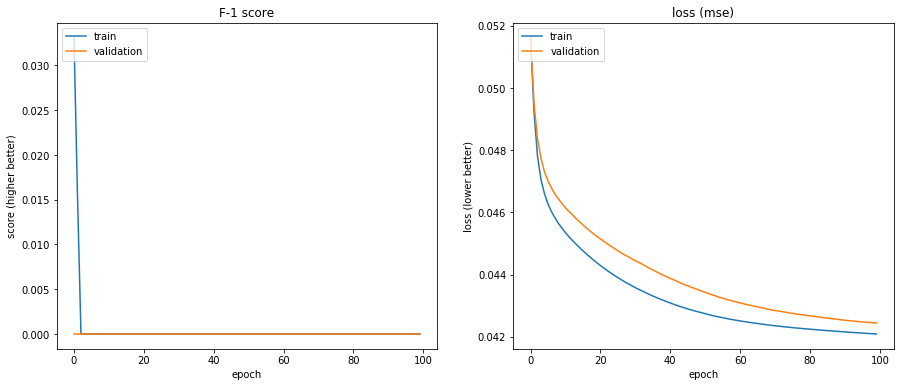

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots (1, 2)

# summarize history for accuracy
axs[0].plot (history.history['fbeta'])
if 'val_fbeta' in history.history:
    axs[0].plot (history.history['val_fbeta'])
axs[0].set (xlabel='epoch', ylabel='score (higher better)', title='F-{} score'.format (PARAM_BETA))
axs[0].legend (['train', 'validation'], loc='upper left')

# summarize history for loss
axs[1].plot (history.history['loss'])
if 'val_loss' in history.history:
    axs[1].plot (history.history['val_loss'])
axs[1].set (xlabel='epoch', ylabel='loss (lower better)', title='loss (mse)')
axs[1].legend (['train', 'validation'], loc='upper left')

fig.set_size_inches ((15., 6.), forward=True)
plt.show ()

**discussion**

Above graphs show the F-beta score per epoch with beta = 1 on the left and the *loss per epoch*, calulated by the mean squared error (mse) on the right.

*loss per epoch*:
- gradient steps start with a loss of 0.052, end by 0.042 and show a smooth concave curve. The curve couldn't be better except a faster drop in the first 10 epochs.
- the worse: mse after 1st epoch = 0.052 - the CNN learns very slow and in tiny steps (1st/2nd epoch: 0.052-0.049 = 0.003)

*F-beta score per epoch*
- evaluation metric immediately drops to zero after some epochs - the CNN doesn't learn anything yet

**reasons / todo**

*input data*

(1) The used dataset only has 240 samples for training, validation and test. This is by far nothing for the CNN.

Todo: retrieve more samples for the dataset

(2) A quick look at random spectrograms show kind of chaotic information - as a human being it is hard to tell if there's any structure behind each key-mode pair. This may apply to the CNN too.

Todo: find additional filter techniques / methods to clearly bring out structures for the CNN

(3) Songs can change in key over their whole length.

Todo: take appropriate sample of a song - ommit bridges, refrains, silent passages, noisy songs

_

*model training*

The model was trained for 100 epochs, each in batches of 10 samples per feedfwd-backprop step. To make sure that the architecture is well suited, more epochs shall be run.

#### compare learning algorithm to benchmarks

[i] below statements can be run without executing the whole notebook

Therefor, go to and execute <a href='#load-learning-algorithm'>load learning algorithm</a>

**TODO** **TODO** **TODO**

In [34]:
score = model.evaluate (X_test, y_test, verbose=1)
print (score)

24/24 [==============================] - 0s 16ms/step
[0.042050689458847046, 8.333333134658005e-09]


## Misc
---

### save learning algorithm

In [30]:
# serialization of model architecture
import os

save_name = os.path.join ('model', 'model.arch.yaml')

print ('>>> saving model...', end=' ', flush=True)
yaml_string = model.to_yaml ()
with open (save_name, 'w') as yaml_file:
    yaml_file.write (yaml_string)
print ('done')

>>> saving model... done


### load learning algorithm

In [33]:
# load model architecture
from keras import models

print ('>>> loading and compiling model...', end=' ', flush=True)
with open (save_name, 'r') as yaml_file:
    yaml_string = yaml_file.read ()
model = models.model_from_yaml (yaml_string)
model.compile (optimizer=opt_sgd, loss=losses.mean_squared_error, metrics=[fbeta])
print ('done')

# load best weights
print ('>>> loading best weights into model...', end=' ', flush=True)
model.load_weights (os.path.join ('model','model.w.best.h5'))
print ('done')

>>> loading and compiling model... done
>>> loading best weights into model... done


In [20]:
idx = 20
test_file = src_spectro_data['filenames'][idx]

test_spectro = path_to_tensor (test_file)
test_pred = model.predict (test_spectro)

print (test_file)
print ('y_true', src_spectro_data['target_names'][src_spectro_data['target'][idx]])
print ('y_pred', src_spectro_data['target_names'][test_pred.argmax ()])

src_spectro/4-0/TROEPPK128F92F33EC.png
y_true 4-0
y_pred 6-1


## Obsolete

**drawbacks** (known, unresolvable issues)

(WRONG) *music keys vs CNN key classes*

See <a href='https://www.researchgate.net/publication/228963946_Audio_onset_detection_using_machine_learning_techniques_the_effect_and_applicability_of_key_and_tempo_information'>Chuan, Ching-Hua & Chew, Elaine. (2018). Audio onset detection using machine learning techniques: the effect and applicability of key and tempo information.</a>, p. 18

The spectrograms show a pitch range given by the <a href='https://en.wikipedia.org/wiki/Scientific_pitch_notation#Table_of_note_frequencies'>Scientific Pitch Notation</a>. By that the range of notes goes from $C_{-1}$ = $0_{MIDI}$ up to $G_9$ = $127_{MIDI}$.

Each note can be the tonic of a music key - for example the key 'C major' exists 11 times (ocatve -1 to 9). Thus the information of 128 keys is now squeezed into 24 key classes.

...